## Difference-in-Differences Estimation

`PyFixest` supports eventy study designs via the canonical two-way fixed effects design Gardner's 2-stage estimator, and the local projections approach following [Dube et al (2023)](https://www.nber.org/papers/w31184).

In [1]:
import pandas as pd

import pyfixest as pf
from pyfixest.did.estimation import did2s, lpdid
from pyfixest.did.visualize import panelview

%load_ext watermark
%watermark --iversions

pyfixest: 0.21.0
pandas  : 2.2.2



In [2]:
url = "https://raw.githubusercontent.com/py-econometrics/pyfixest/master/pyfixest/did/data/df_het.csv"
df_het = pd.read_csv(url)
df_het.head()

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
0,1,33,Group 2,7.043016,2010,1990,0.066159,False,-20.0,-6,-0.086466,0,0.0,7.022709
1,1,33,Group 2,7.043016,2010,1991,-0.030980,False,-19.0,-6,0.766593,0,0.0,7.778628
2,1,33,Group 2,7.043016,2010,1992,-0.119607,False,-18.0,-6,1.512968,0,0.0,8.436377
3,1,33,Group 2,7.043016,2010,1993,0.126321,False,-17.0,-6,0.021870,0,0.0,7.191207
4,1,33,Group 2,7.043016,2010,1994,-0.106921,False,-16.0,-6,-0.017603,0,0.0,6.918492


### Examining Treatment Timing

Before any DiD estimation, we need to examine the treatment timing, since it is crucial to our choice of estimator. 

<Axes: title={'center': 'Treatment Assignment Cohorts'}, xlabel='Year', ylabel='Cohort'>

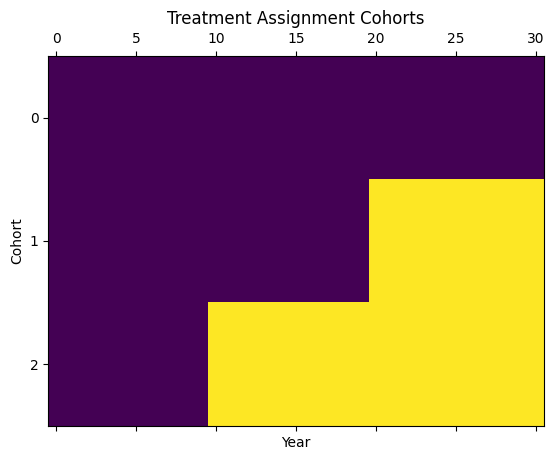

In [3]:
panelview(
    df_het,
    unit="unit", time="year", treat="treat",
    collapse_to_cohort=True,
    sort_by_timing=True,
    ylab="Cohort", xlab="Year",
    title = "Treatment Assignment Cohorts",
)

We immediately see that we have staggered adoption of treatment, which implies that a naive application of 2WFE might yield biased estimates under substantial effect heterogeneity.

We can also plot treatment assignment in a disaggregated fashion, which gives us a sense of cohort sizes.

<Axes: title={'center': 'Treatment Assignment (all units)'}, xlabel='Year', ylabel='Cohort'>

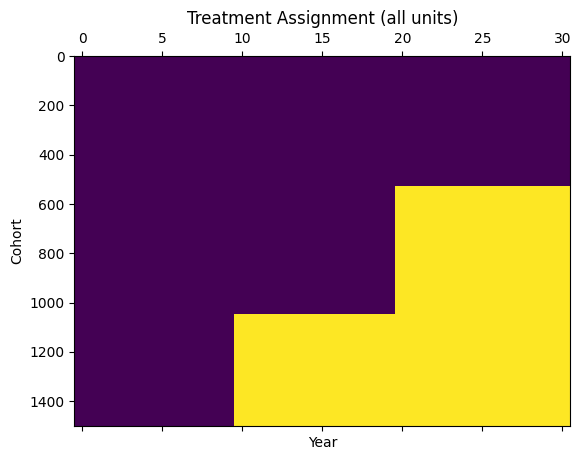

In [4]:
panelview(
    df_het,
    unit="unit", time="year", treat="treat",
    sort_by_timing=True,
    ylab="Cohort", xlab="Year",
    title = "Treatment Assignment (all units)",
)

### DiD Estimation via `feols()`, `did2s()` and `lpdid()`

We can estimate a simple two-way fixed effects DiD regression via `feols()`:

In [3]:
fit_twfe = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year",
    df_het,
    vcov={"CRV1": "state"},
)

To do the same via Gardners 2-stage estimator, we employ the the `did2s()` function: 

In [4]:
fit_did2s = did2s(
    df_het,
    yname="dep_var",
    first_stage="~ 0 | state + year",
    second_stage="~i(rel_year,ref=-1.0)",
    treatment="treat",
    cluster="state",
)

Last, we can estimate the ATT for each time period via local projections by using the `lpdid()` function: 

In [5]:
fit_lpdid = lpdid(
    data=df_het,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=False,
)

Let's look at some results: 

In [6]:
figsize = [1200, 400]

In [7]:
fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
).show()

In [8]:
fit_did2s.iplot(
    coord_flip=False,
    title="DID2s-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
).show()

In [9]:
fit_lpdid.iplot(
    coord_flip=False,
    title="Local-Projections-Estimator",
    figsize=figsize,
    yintercept=0,
    xintercept=18.5,
).show()

What if we are not interested in the ATT per treatment period, but in a pooled effects? 

In [10]:
fit_twfe = pf.feols(
    "dep_var ~ i(treat) | unit + year",
    df_het,
    vcov={"CRV1": "state"},
)

fit_did2s = did2s(
    df_het,
    yname="dep_var",
    first_stage="~ 0 | unit + year",
    second_stage="~i(treat)",
    treatment="treat",
    cluster="state",
)

fit_lpdid = lpdid(
    data=df_het,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=True,
)

In [11]:
fit_twfe.tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
C(treat)[T.True],1.98254,0.019331,102.55618,0.0,1.943439,2.021642


In [12]:
fit_did2s.tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
C(treat)[T.True],2.230482,0.024709,90.271437,0.0,2.182052,2.278911


In [13]:
fit_lpdid.tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%,N
treat_diff,2.506746,0.071357,35.129648,0.0,2.362413,2.65108,5716.0
